# ResNet Ablation Study

## ResNet 기본 블록

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model

import matplotlib.pyplot as plt

In [2]:
def build_basic(
    input_layer,
    channel=64,
    strides1=1,
    skip=True,
):
    x = input_layer
    if skip:
        shortcut = layers.Conv2D(
            filters=channel,
            kernel_size=(1, 1),
            strides=strides1,
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
        )(x)

    x = layers.Conv2D(
        filters=channel,
        kernel_size=(3, 3),
        strides=strides1,
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(
        filters=channel,
        kernel_size=(3, 3),
        activation="linear",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x = layers.BatchNormalization()(x)

    if skip:
        x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    return x

In [3]:
def build_bottleneck(
    input_layer,
    channel=64,
    strides1=1,
    skip=True,
):

    x = input_layer
    if skip:
        shortcut = layers.Conv2D(
            filters=channel,
            kernel_size=(1, 1),
            strides=strides1,
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
        )(x)

    x = layers.Conv2D(
        filters=channel // 4,
        kernel_size=(1, 1),
        strides=strides1,
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(
        filters=channel // 4,
        kernel_size=(3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(
        filters=channel,
        kernel_size=(1, 1),
        activation="linear",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x = layers.BatchNormalization()(x)

    if skip:
        x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    return x

## ResNet-34, ResNet-50

In [4]:
def build_resnet(input_shape=(224, 224, 3), is_50=False, num_classes=1):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2), strides=2)(x)

    if is_50:
        build_block = build_bottleneck
        c_lst = [256, 512, 1024, 2048]
    else:
        build_block = build_basic
        c_lst = [64, 128, 256, 512]

    for _ in range(3):
        x = build_block(x, channel=c_lst[0])

    x = build_block(x, channel=c_lst[1], strides1=2)
    for _ in range(3):
        x = build_block(x, channel=c_lst[1])

    x = build_block(x, channel=c_lst[2], strides1=2)
    for _ in range(5):
        x = build_block(x, channel=c_lst[2])

    x = build_block(x, channel=c_lst[3], strides1=2)
    for _ in range(2):
        x = build_block(x, channel=c_lst[3])

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_49 (Conv2D)             (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_33 (BatchN  (None, 112, 112, 64  256        ['conv2d_49[0][0]']              
 ormalization)                  )                                                           

## Plain 네트워크

In [7]:
def build_plainnet(input_shape=(224, 224, 3), is_50=False, num_classes=1):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2), strides=2)(x)

    if is_50:
        build_block = build_bottleneck
        c_lst = [256, 512, 1024, 2048]
    else:
        build_block = build_basic
        c_lst = [64, 128, 256, 512]

    for _ in range(3):
        x = build_block(x, channel=c_lst[0], skip=False)

    x = build_block(x, channel=c_lst[1], strides1=2, skip=False)
    for _ in range(3):
        x = build_block(x, channel=c_lst[1], skip=False)

    x = build_block(x, channel=c_lst[2], strides1=2, skip=False)
    for _ in range(5):
        x = build_block(x, channel=c_lst[2], skip=False)

    x = build_block(x, channel=c_lst[3], strides1=2, skip=False)
    for _ in range(2):
        x = build_block(x, channel=c_lst[3], skip=False)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
plainnet_34 = build_plainnet(input_shape=(224, 224, 3), is_50=False)
plainnet_34.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_114 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_82 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_34 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_115 (Conv2D)         (None, 56, 56, 64)        3692

In [9]:
plainnet_50 = build_plainnet(input_shape=(224, 224, 3), is_50=True)
plainnet_50.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_147 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_115 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_51 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_148 (Conv2D)         (None, 56, 56, 64)        4160

## Ablation Study

### 데이터셋 준비

In [10]:
import tensorflow_datasets as tfds


(raw_train, raw_validation, raw_test), metadata = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True,
)

In [11]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [12]:
IMG_SIZE = 224  # 리사이징할 이미지의 크기


def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image / 127.5) - 1  # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [13]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [14]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

### 모델 정의 및 훈련

In [15]:
EPOCHS = 20
args = {
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "metrics": ["acc"],
}

In [16]:
plainnet_34.compile(**args)
history1 = plainnet_34.fit(train_batches, epochs=EPOCHS, validation_data=val_batches)

Epoch 1/20
291/291 [==============================] - 74s 229ms/step - loss: 0.6627 - acc: 0.6114 - val_loss: 1.2319 - val_acc: 0.4884
Epoch 2/20
291/291 [==============================] - 66s 222ms/step - loss: 0.5773 - acc: 0.7051 - val_loss: 0.9738 - val_acc: 0.6887
Epoch 3/20
291/291 [==============================] - 66s 222ms/step - loss: 0.5051 - acc: 0.7543 - val_loss: 0.9133 - val_acc: 0.7016
Epoch 4/20
291/291 [==============================] - 66s 223ms/step - loss: 0.4386 - acc: 0.7962 - val_loss: 0.6223 - val_acc: 0.7713
Epoch 5/20
291/291 [==============================] - 66s 222ms/step - loss: 0.3736 - acc: 0.8320 - val_loss: 0.8979 - val_acc: 0.7223
Epoch 6/20
291/291 [==============================] - 66s 222ms/step - loss: 0.3295 - acc: 0.8554 - val_loss: 1.3546 - val_acc: 0.7382
Epoch 7/20
291/291 [==============================] - 66s 223ms/step - loss: 0.2892 - acc: 0.8759 - val_loss: 0.5427 - val_acc: 0.8362
Epoch 8/20
291/291 [==============================] - 6

In [17]:
plainnet_50.compile(**args)
history2 = plainnet_50.fit(train_batches, epochs=EPOCHS, validation_data=val_batches)

Epoch 1/20
291/291 [==============================] - 97s 313ms/step - loss: 0.7191 - acc: 0.5279 - val_loss: 0.6993 - val_acc: 0.5748
Epoch 2/20
291/291 [==============================] - 91s 309ms/step - loss: 0.6710 - acc: 0.5877 - val_loss: 0.7875 - val_acc: 0.5206
Epoch 3/20
291/291 [==============================] - 93s 317ms/step - loss: 0.6388 - acc: 0.6400 - val_loss: 0.7817 - val_acc: 0.5499
Epoch 4/20
291/291 [==============================] - 91s 309ms/step - loss: 0.6181 - acc: 0.6602 - val_loss: 0.6470 - val_acc: 0.6488
Epoch 5/20
291/291 [==============================] - 91s 309ms/step - loss: 0.6025 - acc: 0.6734 - val_loss: 0.6297 - val_acc: 0.6629
Epoch 6/20
291/291 [==============================] - 91s 309ms/step - loss: 0.5764 - acc: 0.6950 - val_loss: 0.6393 - val_acc: 0.6552
Epoch 7/20
291/291 [==============================] - 91s 309ms/step - loss: 0.5554 - acc: 0.7121 - val_loss: 0.6051 - val_acc: 0.6849
Epoch 8/20
291/291 [==============================] - 9

In [18]:
resnet_34.compile(**args)
history3 = resnet_34.fit(train_batches, epochs=EPOCHS, validation_data=val_batches)

Epoch 1/20
291/291 [==============================] - 78s 251ms/step - loss: 0.7568 - acc: 0.6466 - val_loss: 1.1570 - val_acc: 0.5107
Epoch 2/20
291/291 [==============================] - 74s 249ms/step - loss: 0.5001 - acc: 0.7579 - val_loss: 0.4984 - val_acc: 0.7571
Epoch 3/20
291/291 [==============================] - 73s 249ms/step - loss: 0.4349 - acc: 0.8029 - val_loss: 0.7094 - val_acc: 0.6797
Epoch 4/20
291/291 [==============================] - 73s 248ms/step - loss: 0.3728 - acc: 0.8339 - val_loss: 0.5160 - val_acc: 0.7889
Epoch 5/20
291/291 [==============================] - 73s 249ms/step - loss: 0.3178 - acc: 0.8655 - val_loss: 1.1014 - val_acc: 0.6509
Epoch 6/20
291/291 [==============================] - 73s 249ms/step - loss: 0.2608 - acc: 0.8890 - val_loss: 0.5248 - val_acc: 0.8306
Epoch 7/20
291/291 [==============================] - 74s 249ms/step - loss: 0.2255 - acc: 0.9051 - val_loss: 0.3650 - val_acc: 0.8508
Epoch 8/20
291/291 [==============================] - 7

In [19]:
resnet_50.compile(**args)
history4 = resnet_50.fit(train_batches, epochs=EPOCHS, validation_data=val_batches)

Epoch 1/20
291/291 [==============================] - 156s 511ms/step - loss: 1.5020 - acc: 0.6129 - val_loss: 1.8705 - val_acc: 0.5404
Epoch 2/20
291/291 [==============================] - 149s 507ms/step - loss: 0.5994 - acc: 0.6803 - val_loss: 0.6458 - val_acc: 0.6156
Epoch 3/20
291/291 [==============================] - 149s 508ms/step - loss: 0.5511 - acc: 0.7220 - val_loss: 1.0899 - val_acc: 0.5761
Epoch 4/20
291/291 [==============================] - 149s 507ms/step - loss: 0.5175 - acc: 0.7447 - val_loss: 0.7723 - val_acc: 0.6144
Epoch 5/20
291/291 [==============================] - 154s 525ms/step - loss: 0.4745 - acc: 0.7729 - val_loss: 0.6711 - val_acc: 0.6522
Epoch 6/20
291/291 [==============================] - 149s 507ms/step - loss: 0.4286 - acc: 0.8053 - val_loss: 0.7088 - val_acc: 0.7128
Epoch 7/20
291/291 [==============================] - 149s 507ms/step - loss: 0.3919 - acc: 0.8243 - val_loss: 0.9380 - val_acc: 0.6371
Epoch 8/20
291/291 [============================

### 학습 과정 및 성능

In [20]:
def draw_hist(history):
    acc = history.history["acc"]
    val_acc = history.history["val_acc"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

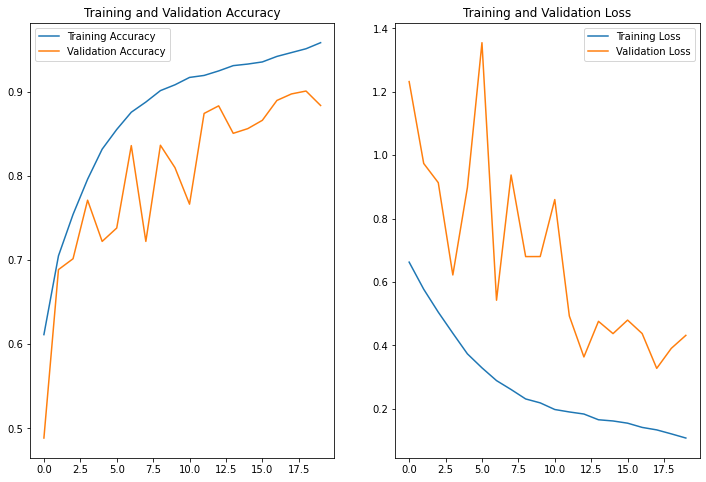

In [21]:
draw_hist(history1)

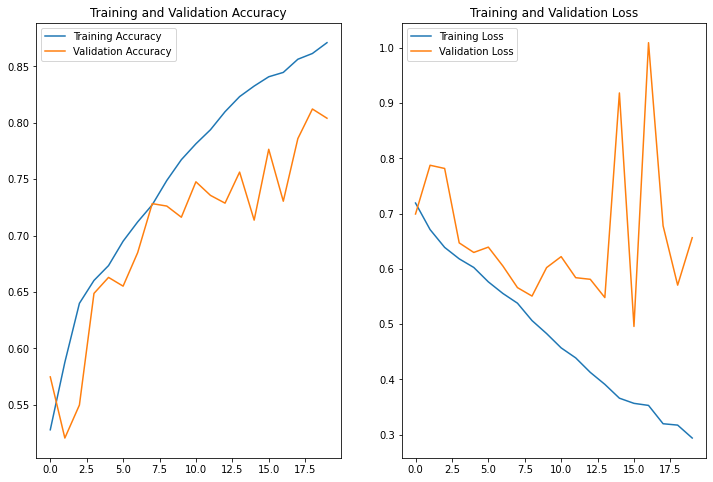

In [22]:
draw_hist(history2)

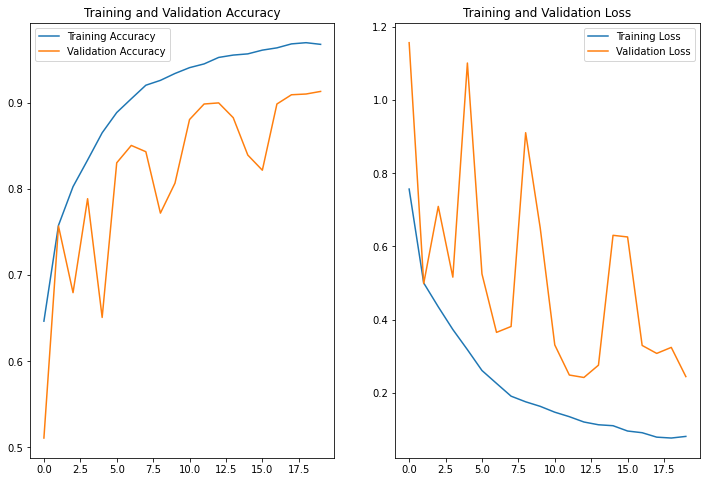

In [23]:
draw_hist(history3)

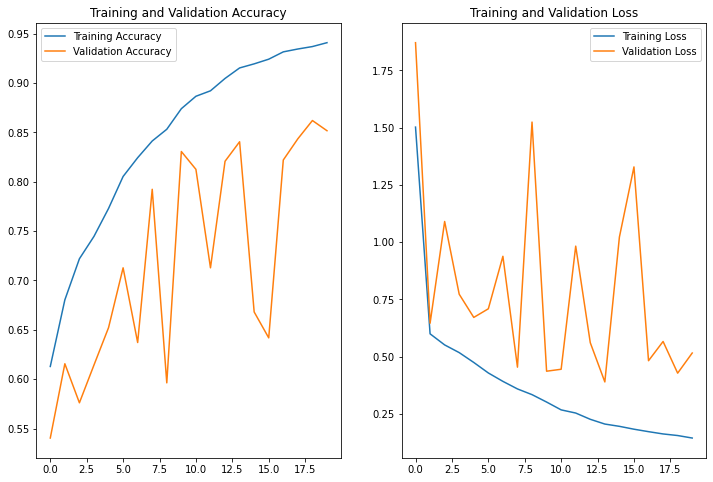

In [24]:
draw_hist(history4)

In [25]:
def compare_hist(hist1, hist2, attr="val_acc"):
    attr1 = hist1.history[attr]
    attr2 = hist2.history[attr]

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(12, 8))
    plt.plot(epochs_range, attr1, label=f"plain {attr}")
    plt.plot(epochs_range, attr2, label=f"resnet {attr}")
    plt.legend()
    plt.show()

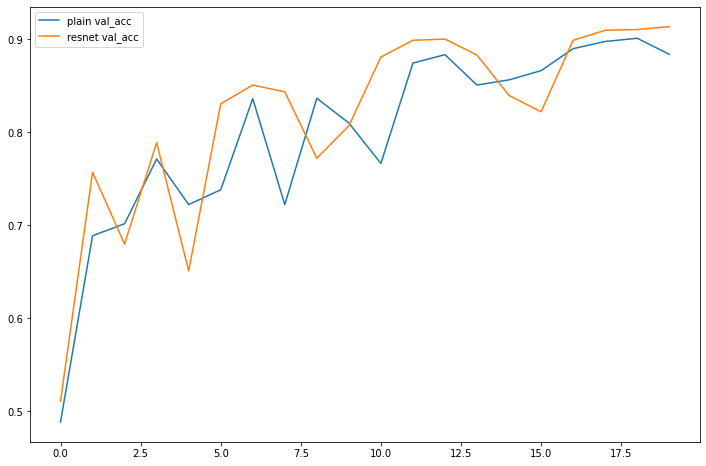

In [26]:
compare_hist(history1, history3)

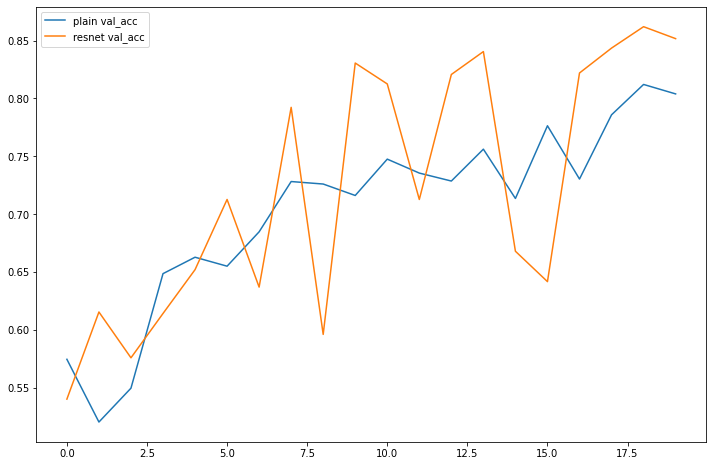

In [27]:
compare_hist(history2, history4)

## 실험결과

| Model | Val Acc |
| --- | --- |
| Plain-34 | 0.901 |
| ResNet-34 | 0.914 |
| Plain-50 | 0.812 |
| ResNet-50 | 0.862 |

- Residual Connection을 적용한 ResNet의 validation acc가 PlainNet의 validation acc보다 높음을 확인할 수 있었습니다.

| Model | Val Acc |
| --- | --- |
| Plain-34 - ResNet-34 | ![34comp](img/g02_comp34.png) |
| Plain-50 - ResNet-50 | ![50com](img/g02_comp50.png) |

## 루브릭

| 평가문항                                                     | 상세기준                                                                                                                  |
| --- | --- |
| 1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?             | 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.                                                                   |
| 2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가? | cats\_vs\_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.                                                          |
| 3. Ablation Study 결과가 바른 포맷으로 제출되었는가?                    | ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다. |

### 루브릭 자체평가

1. ResNet-34의 기본적인 residual block을 구현하였고, Resnet-50에서 사용되는 bottleneck block을 구현하였다.
2. train loss와 validation loss가 장기적으로 감소하는 추세임을 확인할 수 있었다.
3. 동일한 epoch만큼 학습시킨 모델들의 성능을 validation acc를 통하여 비교하였다.